# Extracting wake and filtering it out of data

Restarting from the downsampled xrarray, extraction of active (without SWR) and quiet wake (with SWR) periods and removing these periods from the recordings.

## Load EMG and packages

In [1]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy import fftpack
import pandas as pd
import mmap
from pathlib import Path

%matplotlib widget

# mmap activated to not store everything in memory

"""def other_mmap(filename, shape, dtype, chunks):
    with open(filename, "rb") as fh:
        # `mmap` duplicates the file descriptor
        # `0` means map the full file
        mm = mmap.mmap(fh.fileno(), 0, access=mmap.ACCESS_READ)

    # coerce to NumPy array of expected type and shape
    a = np.asarray(mm).view(dtype).reshape(shape)

    # Don't call `asarray`
    # name=False to avoid hashing
    a_d = da.from_array(a, chunks=chunks, asarray=False, name=False)
    return a_d"""

folder_base = Path('C:/Users/AudreyHay/Desktop/openephys/2024-02-29_09-45-35/Record Node 103/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data')
#folder_base = Path('/mnt/data/ahay/')
filename = folder_base / f'RawDataChannelExtractedDS2.npy'
All = np.load(filename, mmap_mode= 'r')
All = All.T
EMG = All[:,22] #Femelle: 58 - 32 = 26 // 0 based : 26-1 = 25 /// Mâle: 0 based uniquement
EMG.shape


(21272960,)

## High pass filter

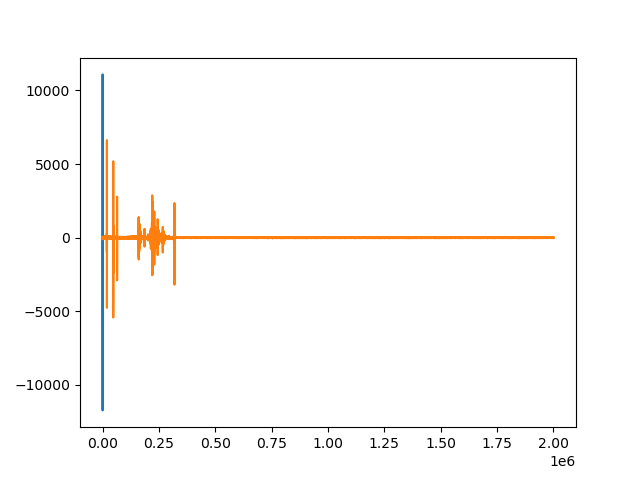

In [2]:
# Filter parameter :
f_lowcut = 200.
f_hicut = 400.
N = 4
fs = 1000
nyq = 0.5 * fs
Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction


# Filter creation :
b, a = signal.butter(N, Wn, 'band')
filt_EMG = signal.filtfilt(b, a, EMG)

# Plot
times = np.arange(0, EMG.size/fs, 1./fs)
timesmin = np.arange(0, EMG.size/fs/60, 1./fs/60)

fig, ax = plt.subplots()
ax.plot(timesmin, filt_EMG)
#ax.plot(timesmin[:2000*fs], filt_EMG[:2000*fs])

plt.plot(filt_EMG[:2000*fs])
#plt.show()

## Continuous Wavelet Transform and projection calculation

In [ ]:
# Parameter and computation of CWT
w = 4.
freq = np.linspace(200, 400, 50)
widths = w*fs / (2*freq*np.pi)
EMGcwt = signal.cwt(EMG, signal.morlet2, widths, w=w)

# Projection calculation
absEMGcwt = np.absolute(EMGcwt)
proj_EMGcwt = np.sum(absEMGcwt, axis = 0)/50
sdproj_EMGcwt = np.std(proj_EMGcwt)
sd3proj_EMGcwt = sdproj_EMGcwt*40
sd05proj_EMGcwt = sdproj_EMGcwt*15



KeyboardInterrupt: 

### Display subset 

Not necessary cell to run

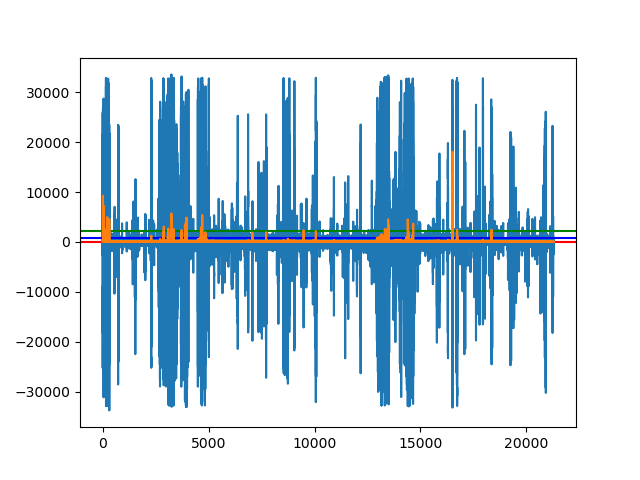

In [ ]:
# Defining subset

#echantillon de 10 secondes (voir les 3 lignes) sample_size = 10000
#start =  np.random.randint(0, EMG.size - sample_size)
#end = start + sample_size
# Defining subset
start = 00000
end = 100000000

tt = times[start:end]
EMGt = EMG[start:end]
EMGcwtt = EMGcwt[:, start:end]
proj_EMGcwtt = proj_EMGcwt[start:end]

plt.figure()
plt.plot(tt, EMGt)
plt.axhline(sdproj_EMGcwt, color='r') # horizontal
plt.axhline(sd3proj_EMGcwt, color='g') # horizontal
plt.axhline(sd05proj_EMGcwt, color='b') # horizontal
plt.plot(tt, proj_EMGcwtt)
plt.show()

## WARNING: Plot only short subsets (~ 10 s), too memory consuming otherwise
#plt.pcolormesh(tt, freq, np.abs(EMGcwt), cmap='viridis', shading='gouraud')
#plt.plot(tt, EMGt)
#plt.show()


In [ ]:
plt.close('all')


## Interpretating signal to extract wake (active and quiet) and sleep

In [ ]:
# Assigning values wake (1, 2) and sleep (0)
# 1 = eveil calme // 2 = eveil énergique
numpnts = EMG.size
EMGstatusRaw = np.zeros(numpnts)
for ind in range(numpnts):
    if proj_EMGcwt[ind]<sd05proj_EMGcwt:
        EMGstatusRaw[ind] = 0
    elif proj_EMGcwt[ind]>sd3proj_EMGcwt:
        EMGstatusRaw[ind] = 2
    else: 
        EMGstatusRaw[ind] = 1

# Expanding borders for wake (1, 2) and sleep (0) to ±1 s around detected muscular activity
EMGstatusRaw2 = np.zeros(numpnts)
for ind in range(numpnts):
    if EMGstatusRaw[ind]>1:
       EMGstatusRaw2[ind-1000:ind+1000] = 2
    elif EMGstatusRaw[ind]==1:
        for ind2 in range(ind-1000, ind+1000):
            if ind2==numpnts:
                break
            elif EMGstatusRaw2[ind2]<2:
                EMGstatusRaw2[ind2] = 1

NameError: name 'proj_EMGcwt' is not defined

Nombre de transitions de 0 à 1 : 92
Nombre de transitions de 1 à 2 : 41
Nombre de transitions de 2 à 1 : 41
Nombre de transitions de 1 à 0 : 92


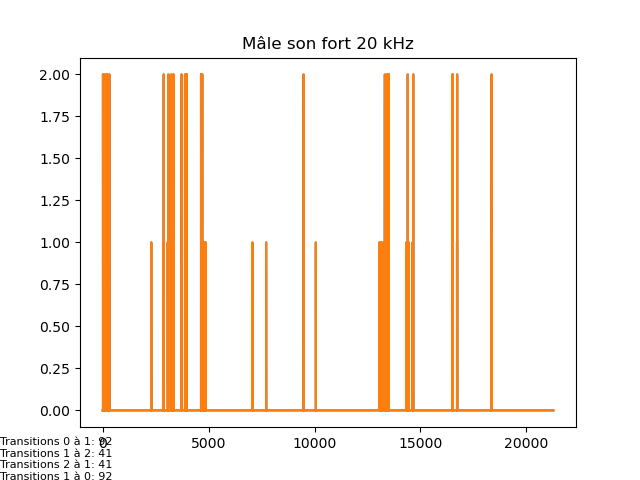

In [ ]:
# Redimensionner EMGstatusRaw_resized et EMGstatusRaw2 à la même longueur que tt
#EMGstatusRaw_resized = np.resize(EMGstatusRaw_resized, tt.shape)
#EMGstatusRaw2 = np.resize(EMGstatusRaw2, tt.shape)

#if needed, plot of the two layers of filters
#plt.close('all')

# Now you can plot both arrays
#plt.plot(tt, EMGstatusRaw_resized)
#plt.plot(tt, EMGstatusRaw2)
#plt.show()

# if needed, plot of the two layers of filters

transitions_0_to_1 = 0
transitions_1_to_2 = 0
transitions_2_to_1 = 0
transitions_1_to_0 = 0

# Compter les transitions
for i in range(1, len(EMGstatusRaw2)):
    if EMGstatusRaw2[i-1] == 0 and EMGstatusRaw2[i] == 1:
        transitions_0_to_1 += 1
    elif EMGstatusRaw2[i-1] == 1 and EMGstatusRaw2[i] == 2:
        transitions_1_to_2 += 1
    elif EMGstatusRaw2[i-1] == 2 and EMGstatusRaw2[i] == 1:
        transitions_2_to_1 += 1
    elif EMGstatusRaw2[i-1] == 1 and EMGstatusRaw2[i] == 0:
        transitions_1_to_0 += 1

# Afficher les résultats
print("Nombre de transitions de 0 à 1 :", transitions_0_to_1)
print("Nombre de transitions de 1 à 2 :", transitions_1_to_2)
print("Nombre de transitions de 2 à 1 :", transitions_2_to_1)
print("Nombre de transitions de 1 à 0 :", transitions_1_to_0)
#0 = sommeil // 1 = éveil très calme // 2 = éveil énergique

plt.close('all')
plt.plot(tt, EMGstatusRaw)
plt.plot(tt, EMGstatusRaw2)
plt.title('Mâle son fort 20 kHz')
plt.figtext(0, 0, f"Transitions 0 à 1: {transitions_0_to_1}\nTransitions 1 à 2: {transitions_1_to_2}\nTransitions 2 à 1: {transitions_2_to_1}\nTransitions 1 à 0: {transitions_1_to_0}", fontsize=8, horizontalalignment='left')
plt.show()


[ 6381.53    6381.54    6386.7475  6386.7575  6391.965   6391.975
  6397.1825  6397.1925  6402.4     6402.41    6407.617   6407.627
  6412.8345  6412.8445  6418.052   6418.062   6423.2695  6423.2795
  6428.487   6428.497   6433.704   6433.7145  6438.9215  6438.9315
  6444.139   6444.149   6449.3565  6449.3665  6454.574   6454.584
  6459.791   6459.8015  6465.0085  6465.0185  6470.226   6470.236
  6475.4435  6475.4535  6480.661   6480.671   6485.8785  6485.8885
  6491.0955  6491.1055  6496.313   6496.323   6501.5305  6501.5405
  6506.748   6506.758   6511.9655  6511.9755  6517.1825  6517.1925
  6522.4     6522.41    6527.6175  6527.6275  6532.835   6532.845
  6538.0525  6538.0625  6543.2695  6543.2795  6548.487   6548.497
  6553.7045  6553.7145  6558.922   6558.932   6564.1395  6564.1495
  6569.3565  6569.3665  7072.0525  7072.0625  7077.2705  7077.2805
  7082.488   7082.498   7087.7055  7087.7155  7092.9225  7092.9325
  7098.14    7098.15    7103.3575  7103.3675  7108.575   7108.585
  

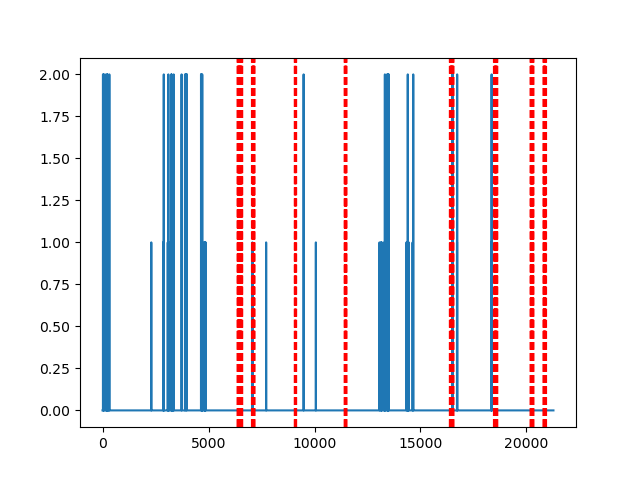

In [ ]:
# Charger les timestamps des stimulations
ttl = np.load("C:/Users/AudreyHay/Desktop/openephys/2024-02-29_09-45-35/Record Node 103/experiment1/recording1/events/Acquisition_Board-100.Rhythm Data/TTL/timestamps.npy")
print(ttl)
ttl = ttl#/60

fig, ax = plt.subplots()
#ax.plot(timesmin[:22000*fs], filt_EMG[:22000*fs])
ax.plot(tt, EMGstatusRaw2)

# Ajouter des traits verticaux pour chaque timestamp de stimulation
for timestamp in ttl:
    ax.axvline(x=timestamp, color='r', linestyle='--')
    pass

plt.show()

In [ ]:
fs = 1000

fig, ax = plt.subplots()
#ax.plot(timesmin[:22000*fs], filt_EMG[:22000*fs])
#ax.plot(tt, EMGstatusRaw2)
duration=10 #seconds

tt2 = np.arange(-duration,duration,1/fs)
avg = np.zeros(tt2.shape)
# Ajouter des traits verticaux pour chaque timestamp de stimulation
for i in range(int(ttl.shape[0]/2)):
    timestamp = ttl[int(i*2)]
    
    avg += EMGstatusRaw2[int((timestamp-duration)*fs):int((timestamp+duration)*fs)]

avg /= int(ttl.shape[0]/2)
ax.plot(tt2,avg)
ax.axvline(x=0, color='r', linestyle='--')


#plt.show()

NameError: name 'plt' is not defined

## To Create boolean masks and to save recordings without movement
#### Creating two masks: one conservative excludes weak muscular activity that can be quiet wake or dozing and one liberal that includes weak muscular activity

In [ ]:
EMGStatusBoolLib = (EMGstatusRaw2>1)
EMGStatusBoolCons = (EMGstatusRaw2>0)


#### Removing wake time from the recordings.
Two files created one with 0 instead of signal during wake and one with the wake time removed

In [ ]:
print(f"EMGStatusBoolLib length: {EMGStatusBoolLib.shape[0]}")

LFP = All[:, 1:32]
LFPwake0 = LFP.copy()
LFPwake0[EMGStatusBoolLib] = 0
np.save('LFPwake0.npy', LFPwake0)

LFPwakeremoved = LFP.copy()
LFPwakeremoved = LFPwakeremoved[~EMGStatusBoolLib, :]
np.save('LFPwakeremoved_2.npy', LFPwakeremoved)
print(f"LFPwake0 length: {LFPwake0.shape[0]}")
print(f"LFPwakeremoved length: {LFPwakeremoved.shape[0]}")

data = {
    'EMGstatus': EMGstatusRaw2,
    'BooleanLiberal' : EMGStatusBoolLib,
    'BooleanConservative' : EMGStatusBoolCons
}
WakeFrame = pd.DataFrame(data, columns=['EMGstatus', 'BooleanLiberal', 'BooleanConservative'])
WakeFrame.to_pickle('EMGframeBoolean_2.pkl')

# Obtenez les indices des valeurs True dans EMGStatusBoolLib
indices = np.where(EMGStatusBoolLib)

# Modifiez les valeurs correspondantes de LFPwake0 à l'aide des indices obtenus
LFPwake0[indices] = 0




EMGStatusBoolLib length: 21272960
LFPwake0 length: 21272960
LFPwakeremoved length: 21174633


In [ ]:
WakeFrame

,EMGstatus,BooleanLiberal,BooleanConservative
0,0.0,False,False
1,0.0,False,False
2,0.0,False,False
3,0.0,False,False
4,0.0,False,False
...,...,...,...
21272955,0.0,False,False
21272956,0.0,False,False
21272957,0.0,False,False
21272958,0.0,False,False


(1000, 3)


ValueError: x and y must have same first dimension, but have shapes (0,) and (1000, 3)

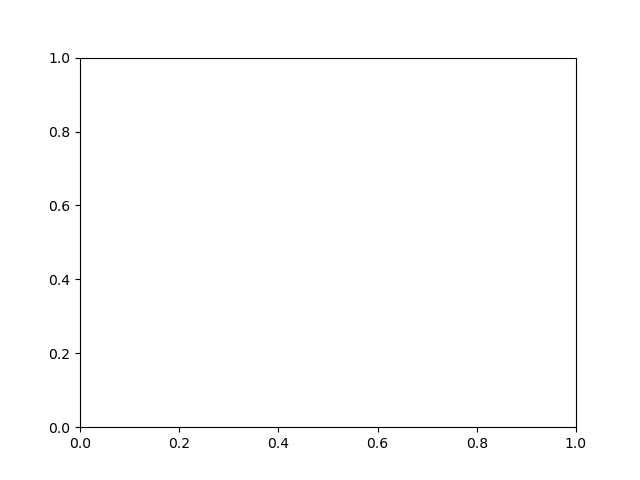

In [ ]:
# Display on a subset (not a necessary step)
start = 1000
end = 2000

LFP = All[start:end, 1:4]
EMGStatusBoolLibt = EMGStatusBoolLib[start:end]
tt2 = tt[start:end]
EMGstatusRaw3 = EMGstatusRaw2[start:end]*2000
tentative = LFP.copy()

# to display LFP with wake time kept but signal set at 0
#tentative[EMGStatusBoolLibt] = 0
#plt.close('all')
#plt.plot(tt2, tentative)
#plt.plot(tt2, EMGstatusRaw3)
#plt.show()

# to display LFP with wake time removed.
tentative = tentative[~EMGStatusBoolLibt, :]
print(tentative.shape)
tt3 = tt[start:tentative.shape[0]]
plt.close('all')
plt.plot(tt3, tentative)
plt.show()
